In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as scio
import folium
from folium.plugins import HeatMap
import math
import bisect
import cv2, os, glob
import json
import torch
from tqdm import tqdm
from tqdm.std import trange
import copy
import pandas as pd
from scipy import interpolate
from copy import deepcopy

import argparse
from collections import OrderedDict
import torch
import torch.nn as nn
from torch.nn import functional as F
import random
from maskrcnn_benchmark.config import cfg


IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

# red, green, blue, yellow, pink, sea, wite, green
color = [(255,0,0), (0,255,0),(0,0,255),\
         (255,255,0),(255,0,255),(0,255,255),(255,255,255),\
         (100,255,0),(100,0,255),(255,100,0),(0,100,255),(255,0,100),(0,255,100),(0,0,0)]
def get_color(i):
    m = len(color)
    return color[i] if i < m else color[i%m]

import warnings
warnings.simplefilter('ignore', np.RankWarning)

In [2]:
import argparse
import cv2, os, glob
from collections import OrderedDict
import torch
import numpy as np
from copy import deepcopy
from scipy import interpolate
from tqdm import tqdm
import logging

import maskrcnn_benchmark.engine.post_process as util
from maskrcnn_benchmark.utils.comm import synchronize, get_rank
import tools as tools


def eliminate_out(sorted_x, sorted_y, confidence = None, image = None):
    out_x = []
    out_y = []

    for lane_x, lane_y in zip(sorted_x, sorted_y):
        
        if len(lane_y) < 3:
            out_x.append(lane_x)
            out_y.append(lane_y)
            continue

        lane_x_along_y = np.array(deepcopy(lane_x))
        lane_y_along_y = np.array(deepcopy(lane_y))

        ind = np.argsort(lane_x_along_y, axis=0)
        lane_x_along_x = np.take_along_axis(lane_x_along_y, ind, axis=0)
        lane_y_along_x = np.take_along_axis(lane_y_along_y, ind, axis=0)
        
        if lane_y_along_x[0] > lane_y_along_x[-1]: #if y of left-end point is higher than right-end
            starting_points = [(lane_x_along_y[0], lane_y_along_y[0]), 
                               (lane_x_along_y[1], lane_y_along_y[1]), 
                               (lane_x_along_y[2], lane_y_along_y[2]),
                                (lane_x_along_x[0], lane_y_along_x[0]), 
                               (lane_x_along_x[1], lane_y_along_x[1]), 
                               (lane_x_along_x[2], lane_y_along_x[2])] # some low y, some left/right x
        else:
            starting_points = [(lane_x_along_y[0], lane_y_along_y[0]), 
                               (lane_x_along_y[1], lane_y_along_y[1]), 
                               (lane_x_along_y[2], lane_y_along_y[2]),
                                (lane_x_along_x[-1], lane_y_along_x[-1]), 
                               (lane_x_along_x[-2], lane_y_along_x[-2]), 
                               (lane_x_along_x[-3], lane_y_along_x[-3])] # some low y, some left/right x            
    
        temp_x = []
        temp_y = []
        for start_point in starting_points:
            temp_lane_x, temp_lane_y = generate_cluster(start_point, lane_x, lane_y, image)
            temp_x.append(temp_lane_x)
            temp_y.append(temp_lane_y)
        
        max_lenght_x = None
        max_lenght_y = None
        max_lenght = 0
        for i, j in zip(temp_x, temp_y):
            if len(i) > max_lenght:
                max_lenght = len(i)
                max_lenght_x = i
                max_lenght_y = j
        out_x.append(max_lenght_x)
        out_y.append(max_lenght_y)

    return out_x, out_y

# image is useless
def generate_cluster(start_point, lane_x, lane_y, image = None):
    cluster_x = [start_point[0]]
    cluster_y = [start_point[1]]

    point = start_point
    while True:
        points = util.get_closest_upper_point(lane_x, lane_y, point, 3)
         
        max_num = -1
        max_point = None

        if len(points) == 0:
            break
        if len(points) < 3:
            for i in points: 
                cluster_x.append(i[0])
                cluster_y.append(i[1])                
            break
        for i in points: 
            num, shortest = util.get_num_along_point(lane_x, lane_y, point, i, image)
            if max_num < num:
                max_num = num
                max_point = i

        total_remain = len(np.array(lane_y)[np.array(lane_y) < point[1]])
        cluster_x.append(max_point[0])
        cluster_y.append(max_point[1])
        point = max_point
        
        if len(points) == 1 or max_num < total_remain/5:
            break

    return cluster_x, cluster_y


def merge_point_with_same_y(in_x, in_y):
    new_in_x, new_in_y = list(), list()

    for lid, (xl, yl) in enumerate(zip(in_x, in_y)):
        new_xl, new_yl = list(), list()
        selected = [False] * len(yl)

        for i in range(len(yl)):
            if selected[i]:
                continue # ignore visited or merged point
            xi_sum = xl[i]
            xi_cnt = 1
            selected[i] = True

            for j in range(i+1, len(yl)):
                if selected[j]: # ignore merged point
                    continue
                if yl[j] == yl[i]: # merge this point
                    selected[j] = True
                    xi_sum += xl[j]
                    xi_cnt += 1
            new_yl.append(yl[i])
            new_xl.append(xi_sum / xi_cnt)
        if len(new_yl) <= 1:
            continue # ignore 1 point line
        new_in_x.append(new_xl)
        new_in_y.append(new_yl)
    return new_in_x, new_in_y


### Fit polyline for each line
### Input line should be asc sorted
def fit_polylines(lines, rx, ry):
    xls = [[pt[0] for pt in line] for line in lines]
    yls = [[pt[1] for pt in line] for line in lines]
    #xls, yls = merge_point_with_same_y(xls, yls)
    new_lines = list()
    for xl, yl in zip(xls, yls):
        if len(yl) <=2: # drop 2 points line
            continue
        
        new_line = list()
        y_min, y_max = yl[0], yl[-1]
        
        #if (y_max - y_min) <= 3.:
        #    ys_sample = np.array([y_min, y_max])
        #else:
        #    ys_sample = np.arange(y_min, y_max, step=3.)
            
        num_pts = max( int(abs(y_max - y_min)/3.0), 2 ) 
        ys_sample = np.linspace(y_min, y_max, num=num_pts, endpoint=True)

        fitted = np.polyfit(yl, xl, 7)[::-1]
        xs_sample = np.zeros(len(ys_sample))
        for i in range(len(fitted)):
            xs_sample += fitted[i]*ys_sample**i

        new_line = [[x*rx, y*ry] for x,y in zip(xs_sample, ys_sample)]
        new_lines.append(new_line)       
    return new_lines

def drop_short_line(lines, thresh=60.):
    outlines = list()
    for l in lines:
        dist = np.sqrt( (l[0][0] - l[-1][0])**2 + (l[0][1] - l[-1][1])**2 )
        if dist > thresh:
            outlines.append(l)
    return outlines

def add_pts_to_image_edge(lines):
    input_width = 1280-1
    input_height = 720-1
    interval = 3.2*2.5
    
    new_lines = list()
    for line in lines:
        x_pt_list = [pt[0] for pt in line]
        y_pt_list = [pt[1] for pt in line]

        max_y = y_pt_list[-1] # bottom pt
        if max_y < input_height: # 255
            y1 = y_pt_list[-2]
            y2 = y_pt_list[-1]
            x1 = x_pt_list[-2]
            x2 = x_pt_list[-1]

            # add points from points(max_y) to img bottom
            while max_y < input_height: # 255
                break_mark = False
                y_new = max_y + interval # 3.2(256/80)
                x_new = x1 + (x2 - x1) * (y_new - y1) / (y2 - y1)
                if x_new < 0:
                    x_new = 0.1
                    y_new = y1 + (y2 - y1) * (x_new - x1) / (x2 - x1)
                    break_mark = True
                elif x_new > input_width:
                    x_new = input_width
                    y_new = y1 + (y2 - y1) * (x_new - x1) / (x2 - x1)
                    break_mark = True
                if y_new > input_height :
                    y_new = input_height
                    x_new = x1 + (x2 - x1) * (y_new - y1) / (y2 - y1)
                    break_mark = True
                elif y_new < 0:
                    y_new = 0.1
                    x_new = x1 + (x2 - x1) * (y_new - y1) / (y2 - y1)
                    break_mark = True
                # check if x/y is valid
                #if ( x_new > input_width or x_new < 0 or y_new > input_height or y_new < 0):
                #    break
                x_pt_list.append(x_new)
                y_pt_list.append(y_new)
                max_y = y_new
                if break_mark:
                    break
        new_line = [[x,y] for x, y in zip(x_pt_list, y_pt_list)] 
        new_lines.append(new_line)
    return new_lines

############### regroup tools ###############
def seprate_and_merge_group_to_line(group):
    lines_with_fit = create_fit_for_sorted_lines(group)
    groups_by_id = create_groups_by_distance(lines_with_fit)
    # print(groups_by_id)
    groups = list()
    for idxs in groups_by_id:
        outline = list()
        for idx in idxs:
            outline.extend( lines_with_fit[idx]["line"] )
            # outline.extend( group[idx] )
        groups.append(outline)
     
    # asc sort along y 
    for i in range(len(groups)):
        groups[i] = sorted(groups[i], key=lambda p: p[1])
        
    return groups

def create_fit_for_sorted_lines(lines):
    outlines = list()
    for l in lines:
        
        l = sorted(l, key=lambda p: p[1])
        yl = [p[1] for p in l]
        xl = [p[0] for p in l]
        fitted = np.polyfit(yl, xl, 5)[::-1]
        
        fitted_x = np.polyfit(xl, yl, 5)[::-1]
        
        
        outlines.append({"line": l, "fitted": fitted, "fitted_x": fitted_x})
    return outlines

# from lines, find close ones of line i, and not in visit list
def find_close_lines(lines, i, visit_list=[], close_list=[], thresh=15):
    close_lines = list()
    for j in range(len(lines)):
        if j == i or j in visit_list or j in close_list:
            continue
        dis, ul_dis, _ = compute_dist_with_fit(lines[j], lines[i])
        # print(i, j, dis)
        if ( dis < thresh and # avg dist
             ul_dis[0] < thresh*0.5 and # upper dist
             ul_dis[1] < thresh ): # lower dist
            close_lines.append(j)
    return close_lines + visit_list


def check_dist_again(lines, t, close_list, thresh=15):
    for i in close_list: # for each line id in close_list
        dis, ul_dis, overlap_rate = compute_dist_with_fit(lines[t], lines[i])
        if ( (dis > thresh or 
              ul_dis[0] > thresh*0.5 or
              ul_dis[1] > thresh) and overlap_rate > 0.3):
            return False
    return True
        

def create_groups_by_distance_orig(lines, thresh=15):
    groups = list()
    selected = [False] * len(lines)
    for i in range(len(lines)):
        if selected[i]:
            continue
        #groups.append(list())
        #groups[-1].append(i)
        selected[i] = True
        close_list = list()
        close_list.append(i)
        visit_list = find_close_lines(lines, i, thresh=thresh)
        while len(visit_list) > 0:
            t = visit_list[0] # give a number id
            del visit_list[0]
            if selected[t]:
                continue
            # before append t into close_list, 
            # we sholud makesure t close to all lines of close_list
            if check_dist_again(lines, t, close_list, thresh=thresh) == False:
                 # t is not close to all lines
                continue
            close_list.append(t)
            selected[t] = True
            visit_list = find_close_lines(lines, t, visit_list, close_list, thresh=thresh)
        # while end
        groups.append(close_list)
    return groups



###########################################
###########################################
def create_groups_by_distance(lines, thresh=15):
    nlines = len(lines)
    selected = [False] * nlines
    groups = list()
    
    if nlines <= 1:
        for i in range( nlines ):
            groups.append([i])
        return groups

    dmat = np.ones((nlines, nlines)) * 1e6
    uldmat = np.ones((nlines, nlines, 2)) * 1e6
    omat = np.ones((nlines, nlines)) * -1
    for i in range(nlines):
        for j in range(i+1, nlines):
            if i == j:
                continue
            else:
                dist1, (udis1, ldis1), overlap1 = compute_dist_with_fit(lines[i], lines[j])
                dist2, (udis2, ldis2), overlap2 = compute_dist_x_with_fit(lines[i], lines[j])
                if dist1 < dist2:
                    dmat[i,j] = dist1
                    dmat[j,i] = dist1
                    uldmat[i,j,0], uldmat[j,i,0] = udis1, udis1
                    uldmat[i,j,1], uldmat[j,i,1] = ldis1, ldis1
                    omat[i,j], omat[j,i] = overlap1, overlap1
                else:
                    dmat[i,j] = dist2
                    dmat[j,i] = dist2
                    uldmat[i,j,0], uldmat[j,i,0] = udis2, udis2
                    uldmat[i,j,1], uldmat[j,i,1] = ldis2, ldis2
                    omat[i,j], omat[j,i] = overlap2, overlap2
    ###########################
    last_num = nlines
    while last_num > 0:
        
        closest_ids = np.argmin(dmat)
        p = int(closest_ids / nlines)
        q = closest_ids % nlines
        if dmat[p,q] > thresh:
            for i in range( nlines ):
                if not selected[i]:
                    groups.append([i])
            return groups

        group = [p, q]
        groups.append(group)
        selected[p] = True
        selected[q] = True
        last_num = len(lines)-2
        
        if last_num <= 0:
            break

        sid = 0
        while sid < nlines:
            # search other line
            if selected[sid]:
                sid += 1
                continue
            
            pass_check = True
            for lid in groups[-1]:
                if (dmat[sid, lid] > thresh) or (uldmat[sid, lid, 0] > thresh/2. 
                                                 and omat[sid, lid] > 0.1):
                # if (dmat[sid, lid] > thresh):
                    pass_check = False
                    break
                    
            if not pass_check:
                sid += 1
                continue
            
            groups[-1].append(sid)
            selected[sid] = True
            last_num -= 1
            sid += 1
        
        # group[-1] done
        for lid in groups[-1]:
            dmat[lid,:] = 1e6
            dmat[:,lid] = 1e6
        # end wihle
          
    return groups      
###########################################
###########################################



# from scipy.spatial.distance import cdist
# lwf1 and lwf2: line_with_fit
def compute_dist_with_fit(lwf1, lwf2, step=3.0):
    #l1 = sorted(l1, key=lambda p: p[1])
    #l2 = sorted(l2, key=lambda p: p[1])
    l1, l2 = lwf1["line"], lwf2["line"]
    f1, f2 = lwf1["fitted"], lwf2["fitted"]
    
    yl1 = [p[1] for p in l1]
    xl1 = [p[0] for p in l1]
    
    yl2 = [p[1] for p in l2]
    xl2 = [p[0] for p in l2]
    
    ub = max(yl1[0], yl2[0])
    lb = min(yl1[-1], yl2[-1])
    
    if ub >= lb: # seprated or connected
        #print("seprated or connected line")
        if yl1[-1] <= yl2[0]:
            p1, p2 = np.array([xl1[-1], yl1[-1]]), np.array([xl2[0], yl2[0]])
            dist = np.sqrt(np.sum( (p1 - p2)**2 ))
            return dist, (-1,-1), -1
        elif yl2[-1] <= yl1[0]:
            p1, p2 = np.array([xl2[-1], yl2[-1]]), np.array([xl1[0], yl1[0]])
            dist = np.sqrt(np.sum( (p1 - p2)**2 ))
            return dist, (-1,-1), -1
        else:
            print("error")
            return 1e6, (-1,-1), -10
    else: # overlaped line
        #print("overlaped line")
        # ys_sample = np.append( np.arange(ub, lb, step=3.0), lb )
        num_pts = max( int((lb - ub)/3.0), 2 ) 
        ys_sample = np.linspace(ub, lb, num=num_pts, endpoint=True)
        
        xs_sample1 = np.zeros(len(ys_sample))
        for i in range(len(f1)):
            xs_sample1 += f1[i]*ys_sample**i
        xs_sample2 = np.zeros(len(ys_sample))
        for i in range(len(f2)):
            xs_sample2 += f2[i]*ys_sample**i
        
        overlap_rate = max( abs((lb - ub)/(yl1[-1] - yl1[0])), abs((lb - ub)/(yl2[-1] - yl2[0])) )
        dists = np.abs(xs_sample1 - xs_sample2)
        dist_sum = np.sum(dists) / len(ys_sample)
        
        
        ### upper and lower distance
        u_range = [0., 214.] # 86
        l_range = [214., 255.] # 170
        u_ids = np.logical_and(ys_sample >= u_range[0], ys_sample <= u_range[1])
        l_ids = np.logical_and(ys_sample > l_range[0],  ys_sample <= l_range[1]) 
        u_dist, l_dist = -1, -1
        if len(dists[u_ids]) > 0:
            u_dist = np.sum( dists[u_ids] ) / len(dists[u_ids])
        if len(dists[l_ids]) > 0:
            l_dist = np.sum( dists[l_ids] ) / len(dists[l_ids])
            
        dist_sum =  ( np.sum(dists[u_ids]) * 2. + np.sum(dists[l_ids]) ) /\
                    ( len(dists[u_ids]) + len(dists[l_ids]) )

        return dist_sum, (u_dist, l_dist), overlap_rate

    
def compute_dist_x_with_fit(lwf1, lwf2, step=3.0):
    #l1 = sorted(l1, key=lambda p: p[1])
    #l2 = sorted(l2, key=lambda p: p[1])
    l1, l2 = lwf1["line"], lwf2["line"]
    f1, f2 = lwf1["fitted_x"], lwf2["fitted_x"]
    
    l1 = sorted(l1, key=lambda p: p[0])
    l2 = sorted(l2, key=lambda p: p[0])
    
    yl1 = [p[1] for p in l1]
    xl1 = [p[0] for p in l1]
    
    yl2 = [p[1] for p in l2]
    xl2 = [p[0] for p in l2]
    
    ub = max(xl1[0], xl2[0])
    lb = min(xl1[-1], xl2[-1])
    
    if ub >= lb:
        if xl1[-1] <= xl2[0]:
            p1, p2 = np.array([xl1[-1], yl1[-1]]), np.array([xl2[0], yl2[0]])
            dist = np.sqrt(np.sum( (p1 - p2)**2 ))
            return dist, (-1,-1), -1
        elif xl2[-1] <= xl1[0]:
            p1, p2 = np.array([xl2[-1], yl2[-1]]), np.array([xl1[0], yl1[0]])
            dist = np.sqrt(np.sum( (p1 - p2)**2 ))
            return dist, (-1,-1), -1
        else:
            print("error")
            return 1e6, (-1,-1), -10
    else:
        num_pts = max( int((lb - ub)/3.0), 2 ) 
        xs_sample = np.linspace(ub, lb, num=num_pts, endpoint=True)
        
        ys_sample1 = np.zeros(len(xs_sample))
        for i in range(len(f1)):
            ys_sample1 += f1[i]*xs_sample**i
        ys_sample2 = np.zeros(len(xs_sample))
        for i in range(len(f2)):
            ys_sample2 += f2[i]*xs_sample**i
        
        overlap_rate = max( abs((lb - ub)/(xl1[-1] - xl1[0])), abs((lb - ub)/(xl2[-1] - xl2[0])) )
        dists = np.abs(ys_sample1 - ys_sample2)
        dist_sum = np.sum(dists) / len(xs_sample)
        
        return dist_sum, (dist_sum, dist_sum), overlap_rate
    
    
def refine(ln, degree=90): # ln: list of [x,y]
    i=2 # 0,1
    
    while True:
        if i >= len(ln):
            break
            
        x1, y1 = ln[i-2][0], ln[i-2][1]
        x2, y2 = ln[i-1][0], ln[i-1][1]
        x3, y3 = ln[i][0], ln[i][1]
        
        vec1 = np.array([x2-x1, y2-y1])
        vec2 = np.array([x3-x2, y3-y2])
        n1 = np.linalg.norm(vec1)
        n2 = np.linalg.norm(vec2)
        vec1 = vec1 / n1
        vec2 = vec2 / n2
        
        d = np.dot(vec1, vec2)
        
        if d <= np.cos(np.radians(degree)): # bad p3
            del ln[i]
        i += 1
        
    return ln

In [3]:
inputs = []
for i in range(4):
    path = "exp/oct29/inference/aicom_lane_test/oct29_265h_r{}.pth".format(i)
    temp = torch.load(path, map_location=torch.device("cpu"))
    inputs.append(temp)
datas = {}
for i in range(4):
    predictions = inputs[i]['predictions']
    for k,v in predictions.items():
        datas[k] = v

outputs_dict = torch.load("exp/oct23/inference/aicom_lane_test/oct23_debug01_m_0.pth", 
                          map_location=torch.device("cpu"))
test_imgs = outputs_dict["test_images"]
def get_imgs(idx):
    img_path = test_imgs[idx].split('/')[-1]
    return cv2.imread('datasets/lane_detection/test/images/'+img_path)

In [6]:
 test_imgs[13701].split('/')[-1]

'LB-XL_814_20131103_145249_f008250_fc00061254_.bmp'

2


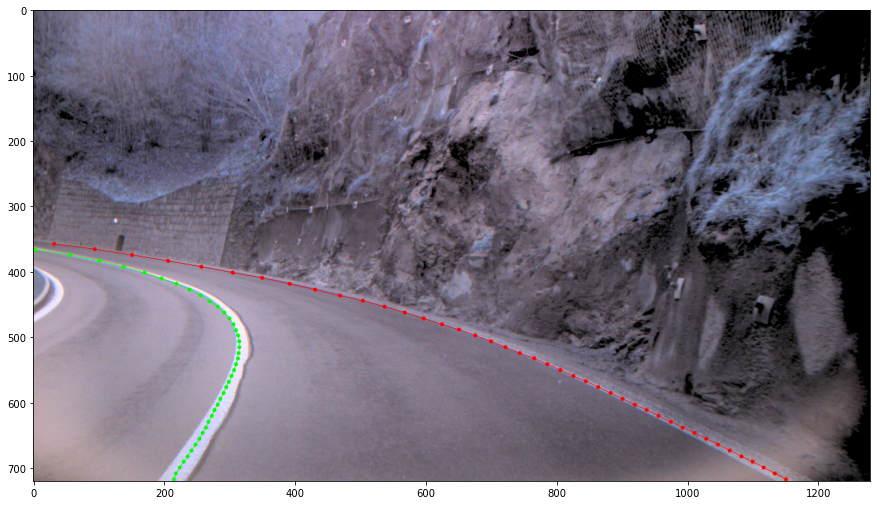

In [8]:
# 27207 45011 45683 7336!! 27207 30792 35651 39627 41760!! 23870 19660 7906
# 30610 # 30610 # 46428 # 41428  38519 19660 7906
# 24080
can_list = [13701, 11864, 17423, 10785, 1360, 163, 2632, 11586, 26175]
img_idx = can_list[2] # 
prediction = datas[img_idx]
rx, ry = 1280/512., 720/256.

### 1. seprate more groups in one original group
outlines = list()
for group in prediction:
    lines_in_group = [it["line"] for it in group]
    probs_in_group = [it["prob"] for it in group]
    groups = seprate_and_merge_group_to_line(lines_in_group)
    for line in groups:
        outlines.append(line)
'''    
outlines = list()
for i, group in enumerate(prediction):
    # seprate group into more groups
    groups = seprate_and_merge_group_to_line(group)
    for line in groups:
        outlines.append(line)
'''

### 2.1 eliminate outlier
x_lines = [[pt[0] for pt in line] for line in outlines]
y_lines = [[pt[1] for pt in line] for line in outlines]
in_x, in_y = util.sort_along_y(x_lines, y_lines)
in_x, in_y = eliminate_out(in_x, in_y)
### 2.2 merge point with same y
in_x, in_y = util.sort_along_y_asc(in_x, in_y)
# in_x, in_y = merge_point_with_same_y(in_x, in_y)

### 3.1. merge close line
def merge_close_line_by_use_fit(lines):
    lines_with_fit = create_fit_for_sorted_lines(lines)
    groups_by_id = create_groups_by_distance(lines_with_fit, thresh=15)
    regrouped_lines = list()
    for lids in groups_by_id:
        outline = list()
        for lid in lids:
            outline.extend( lines_with_fit[lid]["line"] )
            # outline.extend( group[lid] )
        outline = sorted(outline, key=lambda pt: pt[1])
        regrouped_lines.append(outline)
    return regrouped_lines, groups_by_id
lines = [[[x,y] for x,y in zip(xl,yl)] for xl,yl in zip(in_x, in_y)]
regrouped_lines, groups_by_id = merge_close_line_by_use_fit(lines)
regrouped_lines, groups_by_id = merge_close_line_by_use_fit(regrouped_lines)


x_lines = [[pt[0] for pt in line] for line in regrouped_lines]
y_lines = [[pt[1] for pt in line] for line in regrouped_lines]
in_x, in_y = util.sort_along_y(x_lines, y_lines)
in_x, in_y = eliminate_out(in_x, in_y)
### 2.2 merge point with same y
in_x, in_y = util.sort_along_y_asc(in_x, in_y)
regrouped_lines = [[[x,y] for x,y in zip(xl,yl)] for xl,yl in zip(in_x, in_y)]


### 4. remove close points
final_lines = fit_polylines(regrouped_lines, rx, ry)







# in_x, in_y = merge_point_with_same_y(in_x, in_y)

### 5. drop short line (thresh => 1280x720)
#final_lines = drop_short_line(final_lines, thresh=200.)
#final_lines = add_pts_to_image_edge(final_lines)


##############################################################
##############################################################
##############################################################
lines = final_lines
im = get_imgs(img_idx)
    
for lid, pts in enumerate(lines):
    for i in range(len(pts)-1):
        x1 = int(pts[i][0])
        y1 = int(pts[i][1])
        x2 = int(pts[i+1][0])
        y2 = int(pts[i+1][1])
        cv2.circle(im, (x1,y1), 3, color[lid], -1)
        cv2.circle(im, (x2,y2), 3, color[lid], -1)
        cv2.line(im, (x1,y1), (x2,y2), color[lid], 1) 
print(len(lines))
plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.show() 

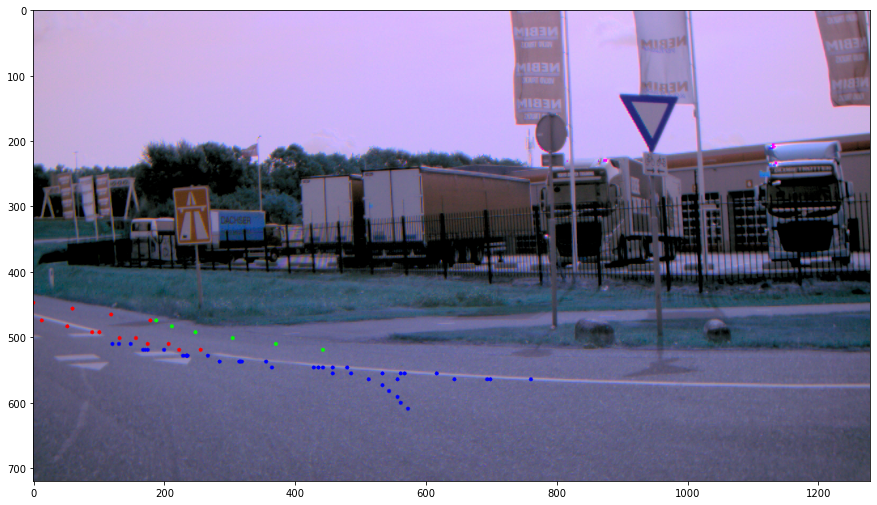

In [35]:
im = get_imgs(img_idx)
for lid, group in enumerate(prediction):
    group = [it["line"] for it in group]
    for line in group:
        for x,y in line:
            x,y = int(x*rx),int(y*ry)
            cv2.circle(im, (x,y), 3, get_color(lid), -1) 

plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.show() 

5


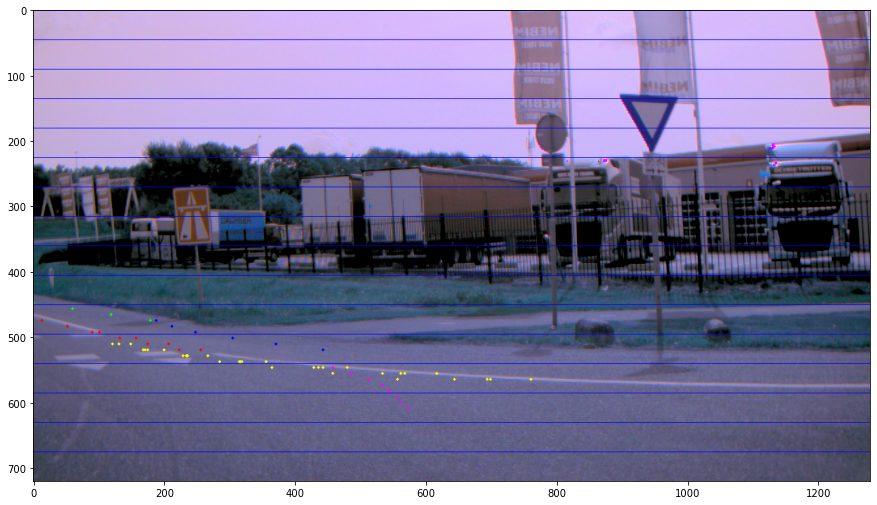

In [40]:
######################### 1
im = get_imgs(img_idx)
for lid, l in enumerate(outlines):
    #if lid not in [2]:
    #    continue
    for x,y in l:
        x,y = int(x*rx),int(y*ry)
        cv2.circle(im, (x,y), 2, get_color(lid), -1)
        
h = 720 / 16.
for i in range( int(720./h) ):
    cv2.line(im, (0, int(h*i)), (1279, int(h*i)), color[2], 1) 

print(len(outlines))
plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.show() 

2


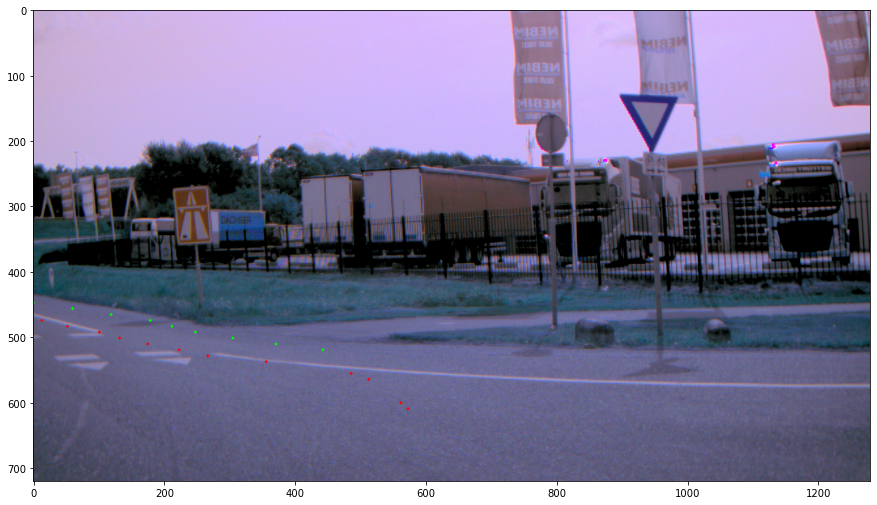

In [47]:
######################### 1
im = get_imgs(img_idx)
for lid,(xl,yl) in enumerate(zip(in_x, in_y)):
    #if lid not in [2]:
    #    continue
    for x,y in zip(xl,yl):
        x,y = int(x*rx),int(y*ry)
        cv2.circle(im, (x,y), 2, get_color(lid), -1)
print(len(in_y))
plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.show() 

2


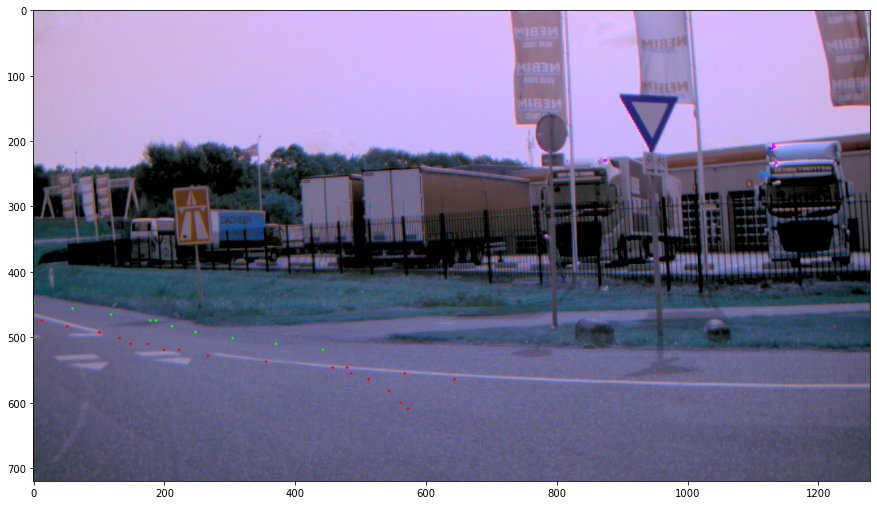

In [41]:
im = get_imgs(img_idx)
for lid, l in enumerate(regrouped_lines):

    for x,y in l:
        x,y = int(x*rx),int(y*ry)
        cv2.circle(im, (x,y), 2, color[lid], -1)
print(len(regrouped_lines))
plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.show() 

In [10]:
import random
randomlist = []
for i in range(0,100):
    n = random.randint(0,len(datas))
    randomlist.append(n)

In [12]:
print(randomlist)

[49408, 42375, 41850, 2871, 39142, 26468, 38185, 53094, 33802, 25782, 50160, 37161, 34587, 17037, 43071, 36595, 7586, 27750, 25080, 31713, 34832, 38259, 10533, 37221, 51329, 4496, 36994, 9950, 35879, 9359, 48704, 37995, 29570, 20787, 45148, 54190, 31046, 5401, 32620, 20703, 14936, 43035, 27883, 27041, 17972, 30903, 33363, 40554, 24615, 31538, 16682, 7274, 8197, 1458, 44328, 21451, 35055, 24582, 21372, 21190, 21068, 31390, 36772, 39251, 25935, 25737, 43975, 9980, 49946, 27228, 17794, 18706, 51850, 4608, 47278, 52336, 45185, 20075, 9721, 16605, 12374, 49932, 33168, 22900, 30200, 11431, 27681, 30119, 6993, 4451, 31007, 22209, 10607, 43364, 52277, 44724, 18254, 37325, 22665, 3187]


In [11]:
from maskrcnn_benchmark.utils.miscellaneous import mkdir

In [297]:
randomlist = [19660,22077,22279,26344,27837,28331,29117,30158,34150,35493,35774,36050,36235,37231,38519,39005,40139,41428,43319,44774,44824,44848,46428,47628,48361,52543,53296]

In [12]:
randomlist = [163, 1151, 1272, 1621, 2091, 2270, 2632, 2842, 3292, 3308, 3504, 3653, 3934, 4058, 4557, 4744, 4939, 5079, 5359, 5459, 5752, 5970, 6518, 6902, 7102, 7948, 8088, 8563, 8911, 9962, 10156, 10718, 11015, 11586, 11793, 12048, 13344, 13913, 14057, 14084, 14492, 14530, 14788, 14837, 14980, 15096, 15257, 15370, 15898, 16086, 16355, 16514, 16621, 16819, 16826, 16840, 17353, 18298, 18513, 18801, 18844, 18953, 19033, 19076, 19686, 20154, 20483, 20644, 20732, 20757, 22052, 22147, 22180, 22282, 22605, 23025, 23238, 23310, 23724, 23787, 23874, 24080, 24151, 24556, 25462, 25551, 26175, 26648, 26748, 27081, 27309, 27658, 27736, 28368, 29836, 30265, 30282, 30365, 30488, 30741, 30816, 31582, 31583, 31597, 32163, 32176, 32558, 32628, 33911, 34345, 34518, 35001, 35305, 35411, 35757, 35990, 36525, 36932, 37086, 37622, 38844, 39004, 39253, 39690, 39969, 40222, 40769, 41525, 41721, 42560, 43457, 43965, 44176, 44306, 44790, 44847, 44906, 44935, 46430, 46512, 46716, 46721, 47028, 47752, 47906, 47921, 48436, 48737, 49037, 49137, 49498, 49611, 50299, 50381, 50611, 50824, 50973, 51401, 51465, 51466, 51552, 51736, 51761, 51844, 51982, 52368, 52645, 52977, 53376, 53427, 53432, 53470, 53500, 53526, 53657, 54011, 54095]

In [17]:
randomlist = [11, 72, 81, 87, 145, 186, 227, 271, 288, 293, 319, 358, 367, 385, 398, 465, 479, 505, 565, 612, 752, 753, 776, 777, 813, 820, 831, 842, 845, 862, 900, 923, 984, 989, 1008, 1016, 1034, 1042, 1058, 1070, 1131, 1158, 1174, 1207, 1209, 1235, 1269, 1322, 1352, 1421, 1442, 1443, 1447, 1454, 1467, 1481, 1548, 1553, 1586, 1606, 1641, 1711, 1748, 1768, 1804, 1825, 1930, 2025, 2050, 2058, 2151, 2194, 2225, 2261, 2276, 2299, 2325, 2343, 2349, 2369, 2448, 2463, 2481, 2577, 2646, 2697, 2716, 2762, 2767, 2792, 2796, 2801, 2847, 2854, 2883, 2938, 2952, 3006, 3012, 3019, 3025, 3043, 3078, 3119, 3155, 3313, 3349, 3361, 3376, 3474, 3480, 3495, 3583, 3652, 3671, 3711, 3719, 3763, 3807, 3832, 3843, 3847, 3852, 3867, 3892, 3939, 3958, 4012, 4026, 4028, 4039, 4041, 4111, 4124, 4156, 4226, 4254, 4288, 4334, 4392, 4398, 4431, 4475, 4486, 4494, 4540, 4550, 4568, 4583, 4619, 4639, 4647, 4673, 4768, 4838, 4852, 4853, 4925, 4929, 4933, 4982, 4995, 5000, 5021, 5138, 5145, 5157, 5190, 5206, 5250, 5307, 5351, 5445, 5480, 5535, 5591, 5601, 5624, 5663, 5753, 5884, 5911, 5936, 5958, 6071, 6097, 6130, 6185, 6236, 6238, 6288, 6315, 6337, 6385, 6390, 6429, 6456, 6495, 6532, 6580, 6601, 6623, 6626, 6703, 6740, 6750, 6796, 6798, 6799, 6802, 6831, 6929, 6993, 7011, 7046, 7047, 7075, 7091, 7128, 7164, 7217, 7252, 7270, 7272, 7414, 7529, 7534, 7545, 7577, 7718, 7728, 7758, 7829, 7851, 7930, 7951, 7985, 8061, 8062, 8081, 8083, 8090, 8107, 8130, 8132, 8143, 8149, 8180, 8235, 8256, 8379, 8405, 8440, 8510, 8565, 8578, 8584, 8613, 8622, 8663, 8668, 8799, 8819, 8839, 8903, 8987, 9022, 9061, 9096, 9110, 9184, 9204, 9209, 9273, 9373, 9437, 9440, 9480, 9516, 9545, 9654, 9725, 9741, 9750, 9800, 9810, 9847, 9908, 9915, 9926, 9931, 9990, 10027, 10055, 10073, 10203, 10287, 10331, 10360, 10362, 10426, 10487, 10589, 10625, 10700, 10701, 10703, 10725, 10742, 10748, 10785, 10794, 10805, 10884, 10913, 10975, 10977, 10995, 11078, 11122, 11207, 11233, 11268, 11269, 11312, 11322, 11398, 11435, 11479, 11480, 11513, 11531, 11533, 11581, 11618, 11648, 11670, 11711, 11731, 11733, 11734, 11767, 11788, 11864, 11884, 11979, 12036, 12037, 12043, 12060, 12080, 12151, 12214, 12291, 12340, 12354, 12397, 12414, 12494, 12501, 12512, 12520, 12527, 12558, 12561, 12621, 12628, 12663, 12688, 12699, 12717, 12742, 12767, 12794, 12808, 12817, 12860, 12862, 12901, 12914, 12924, 12975, 13009, 13033, 13078, 13093, 13146, 13174, 13197, 13204, 13248, 13262, 13281, 13295, 13299, 13369, 13376, 13458, 13526, 13630, 13658, 13681, 13701, 13709, 13726, 13819, 13943, 13959, 13988, 14051, 14068, 14076, 14183, 14221, 14334, 14361, 14367, 14369, 14421, 14485, 14548, 14597, 14632, 14765, 14840, 14845, 14882, 14892, 14903, 14919, 14953, 15032, 15052, 15081, 15186, 15201, 15203, 15217, 15245, 15295, 15323, 15359, 15361, 15453, 15469, 15494, 15507, 15533, 15569, 15582, 15683, 15701, 15739, 15745, 15770, 15776, 15841, 15842, 15862, 15868, 15885, 15890, 15910, 15945, 15979, 16081, 16082, 16125, 16160, 16241, 16277, 16282, 16291, 16295, 16316, 16323, 16332, 16353, 16370, 16402, 16501, 16509, 16530, 16533, 16605, 16608, 16631, 16682, 16688, 16690, 16709, 16719, 16843, 16893, 16974, 17000, 17013, 17030, 17053, 17054, 17111, 17220, 17235, 17269, 17284, 17288, 17294, 17423, 17430, 17440, 17495, 17582, 17591, 17619, 17670, 17695, 17697, 17812, 17828, 17874, 17880, 17902, 17991, 17994, 17996, 18039, 18091, 18111, 18120, 18233, 18236, 18276, 18315, 18341, 18343, 18377, 18380, 18409, 18474, 18521, 18548, 18562, 18570, 18646, 18679, 18731, 18823, 18852, 18862, 18883, 18911, 18947, 18948, 19015, 19024, 19050, 19063, 19065, 19068, 19081, 19104, 19162, 19166, 19185, 19220, 19337, 19338, 19401, 19402, 19444, 19516, 19574, 19618, 19722, 19747, 19753, 19759, 19816, 19825, 19909, 19947, 19958, 20005, 20021, 20028, 20063, 20080, 20083, 20104, 20122, 20182, 20190, 20208, 20223, 20277, 20320, 20362, 20389, 20491, 20494, 20508, 20521, 20532, 20561, 20596, 20643, 20686, 20707, 20719, 20775, 20777, 20802, 20803, 20902, 20935, 20974, 21013, 21017, 21077, 21117, 21159, 21164, 21175, 21181, 21204, 21354, 21385, 21417, 21433, 21435, 21495, 21521, 21539, 21551, 21560, 21708, 21759, 21780, 21787, 21813, 21852, 21924, 21972, 21976, 21978, 21983, 22016, 22045, 22051, 22073, 22078, 22113, 22155, 22157, 22163, 22217, 22241, 22297, 22300, 22353, 22354, 22391, 22460, 22542, 22596, 22611, 22624, 22710, 22723, 22749, 22762, 22809, 22827, 22848, 22870, 22877, 22884, 23057, 23083, 23100, 23136, 23155, 23183, 23193, 23226, 23230, 23271, 23288, 23397, 23404, 23451, 23461, 23478, 23510, 23627, 23647, 23658, 23702, 23753, 23839, 23866, 23913, 23967, 24005, 24034, 24141, 24145, 24185, 24190, 24243, 24287, 24296, 24368, 24414, 24421, 24428, 24488, 24515, 24535, 24571, 24704, 24731, 24761, 24779, 24782, 24807, 24819, 24841, 24860, 24884, 24893, 25095, 25105, 25128, 25174, 25200, 25208, 25315, 25318, 25325, 25400, 25454, 25461, 25474, 25481, 25502, 25586, 25607, 25683, 25717, 25728, 25754, 25792, 25793, 25805, 25876, 25910, 25923, 25946, 25956, 25994, 26013, 26014, 26025, 26071, 26097, 26117, 26204, 26313, 26322, 26323, 26365, 26429, 26504, 26557, 26602, 26653, 26670, 26690, 26712, 26798, 26848, 26881, 26939, 26964, 26989, 27003, 27201, 27216, 27226, 27228, 27269, 27344, 27352, 27387, 27390, 27538, 27563, 27599, 27690, 27710, 27841, 27926, 27935, 27979, 28066, 28099, 28129, 28191, 28294, 28390, 28394, 28425, 28450, 28512, 28590, 28619, 28637, 28664, 28704, 28713, 28751, 28881, 28886, 28899, 29015, 29059, 29062, 29071, 29101, 29177, 29199, 29216, 29295, 29301, 29307, 29470, 29531, 29695, 29711, 29718, 29720, 29727, 29747, 29788, 29790, 29804, 29900, 29946, 29958, 29969, 29983, 30019, 30099, 30119, 30130, 30134, 30181, 30228, 30231, 30268, 30295, 30314, 30329, 30330, 30503, 30519, 30605, 30640, 30654, 30668, 30753, 30761, 30774, 30780, 30793, 30799, 30801, 30811, 30894, 30914, 31031, 31125, 31152, 31161, 31200, 31218, 31416, 31420, 31486, 31560, 31570, 31574, 31592, 31630, 31632, 31640, 31651, 31674, 31681, 31689, 31723, 31744, 31784, 31821, 31827, 31878, 31913, 31920, 31922, 31952, 31972, 31987, 31992, 32004, 32073, 32102, 32195, 32196, 32278, 32319, 32328, 32345, 32411, 32479, 32489, 32537, 32584, 32606, 32611, 32623, 32642, 32660, 32677, 32690, 32747, 32762, 32773, 32845, 32919, 32964, 33061, 33065, 33069, 33134, 33185, 33207, 33252, 33283, 33289, 33336, 33345, 33409, 33427, 33526, 33544, 33597, 33669, 33690, 33717, 33751, 33770, 33778, 33786, 33817, 33849, 33975, 34013, 34016, 34019, 34025, 34028, 34119, 34127, 34149, 34169, 34172, 34194, 34216, 34255, 34276, 34283, 34295, 34349, 34365, 34367, 34372, 34425, 34455, 34473, 34485, 34534, 34585, 34601, 34697, 34711, 34737, 34784, 34814, 34818, 34824, 34827, 34845, 34908, 34926, 34944, 35048, 35085, 35101, 35118, 35153, 35169, 35179, 35196, 35201, 35364, 35375, 35403, 35408, 35410, 35471, 35561, 35592, 35605, 35615, 35701, 35775, 35783, 35828, 35868, 35910, 35968, 36013, 36137, 36148, 36167, 36182, 36208, 36237, 36247, 36251, 36266, 36346, 36427, 36429, 36432, 36443, 36445, 36463, 36499, 36509, 36550, 36553, 36601, 36736, 36781, 36787, 36824, 36828, 36842, 36851, 36858, 36933, 36936, 37077, 37096, 37106, 37154, 37185, 37188, 37227, 37246, 37249, 37250, 37286, 37287, 37306, 37477, 37505, 37518, 37531, 37612, 37632, 37640, 37672, 37680, 37707, 37755, 37839, 37860, 38000, 38001, 38047, 38209, 38299, 38310, 38507, 38540, 38552, 38573, 38581, 38614, 38637, 38723, 38730, 38754, 38796, 38800, 38872, 38886, 38910, 38950, 39008, 39016, 39019, 39064, 39069, 39126, 39169, 39180, 39219, 39224, 39268, 39304, 39306, 39333, 39360, 39365, 39387, 39418, 39445, 39545, 39613, 39637, 39709, 39743, 39748, 39781, 39795, 39800, 39828, 39832, 39847, 39860, 39870, 39877, 39935, 39972, 40012, 40035, 40071, 40077, 40122, 40133, 40166, 40181, 40225, 40233, 40269, 40270, 40372, 40394, 40403, 40437, 40442, 40492, 40536, 40604, 40805, 40815, 40838, 40839, 40928, 40934, 40973, 41056, 41057, 41083, 41087, 41090, 41093, 41118, 41125, 41170, 41240, 41254, 41296, 41331, 41357, 41379, 41447, 41511, 41582, 41630, 41688, 41690, 41747, 41784, 41793, 41836, 41838, 41841, 41845, 41903, 41939, 41964, 41987, 42025, 42035, 42149, 42229, 42235, 42247, 42285, 42286, 42319, 42325, 42345, 42347, 42410, 42498, 42522, 42528, 42536, 42609, 42626, 42690, 42789, 42800, 42830, 42849, 42856, 42868, 42885, 42897, 42939, 42993, 43004, 43020, 43051, 43177, 43312, 43320, 43332, 43379, 43417, 43424, 43500, 43531, 43551, 43552, 43578, 43601, 43621, 43633, 43669, 43751, 43771, 43783, 43797, 43805, 43879, 43915, 43972, 44139, 44159, 44211, 44250, 44292, 44326, 44330, 44350, 44370, 44459, 44713, 44729, 44733, 44746, 44788, 44793, 44895, 44939, 44944, 44951, 45010, 45062, 45069, 45153, 45239, 45248, 45265, 45289, 45323, 45355, 45368, 45388, 45406, 45427, 45437, 45464, 45508, 45655, 45658, 45672, 45677, 45684, 45737, 45752, 45758, 45816, 45823, 45910, 45920, 45941, 45943, 45963, 45977, 45984, 46000, 46018, 46071, 46072, 46084, 46110, 46135, 46145, 46160, 46164, 46173, 46238, 46248, 46249, 46254, 46398, 46406, 46438, 46458, 46504, 46524, 46615, 46651, 46752, 46800, 46839, 46842, 46854, 46865, 46874, 46895, 47003, 47006, 47047, 47061, 47106, 47130, 47143, 47167, 47173, 47284, 47308, 47341, 47345, 47352, 47391, 47398, 47434, 47472, 47558, 47562, 47617, 47624, 47688, 47696, 47731, 47741, 47748, 47757, 47773, 47784, 47790, 47815, 47823, 47825, 47833, 47873, 47882, 47895, 47904, 47909, 47923, 47992, 48003, 48071, 48110, 48154, 48158, 48201, 48207, 48279, 48315, 48330, 48431, 48463, 48586, 48642, 48675, 48676, 48680, 48691, 48768, 48798, 48810, 48820, 48984, 49048, 49110, 49118, 49120, 49162, 49229, 49233, 49288, 49311, 49330, 49334, 49344, 49492, 49519, 49608, 49625, 49666, 49823, 49842, 49868, 49913, 50042, 50047, 50088, 50131, 50138, 50148, 50165, 50172, 50190, 50290, 50404, 50432, 50510, 50552, 50605, 50644, 50733, 50739, 50780, 50841, 50904, 50911, 50939, 50944, 50953, 50964, 51069, 51071, 51087, 51122, 51139, 51224, 51251, 51292, 51318, 51328, 51356, 51477, 51484, 51531, 51554, 51628, 51694, 51809, 51821, 51829, 51841, 51912, 51920, 51921, 51971, 51972, 51994, 52074, 52109, 52141, 52176, 52193, 52205, 52214, 52244, 52265, 52299, 52305, 52306, 52326, 52351, 52378, 52459, 52567, 52568, 52615, 52629, 52652, 52697, 52802, 52807, 52817, 52863, 52866, 52947, 52954, 52958, 52985, 53017, 53018, 53054, 53065, 53097, 53119, 53122, 53148, 53153, 53214, 53217, 53231, 53263, 53314, 53404, 53486, 53519, 53545, 53555, 53558, 53622, 53642, 53665, 53683, 53687, 53695, 53744, 53759, 53889, 53891, 53961, 53965, 53993, 54013, 54026, 54090, 54148, 54172]

In [18]:
folder_path = './out_img/test_21'
mkdir(folder_path)
for img_idx in tqdm(randomlist):
    prediction = datas[img_idx]
    rx, ry = 1280/512., 720/256.

    ### 1. seprate more groups in one original group
    outlines = list()
    for i, group in enumerate(prediction):
        # seprate group into more groups
        lines_in_group = [it["line"] for it in group]
        probs_in_group = [it["prob"] for it in group]
        outline = list()
        for line in lines_in_group:
            outline.extend(line)
        outline = sorted(outline, key=lambda pt: pt[1])
        outlines.append(outline)

    ##############################################################
    ##############################################################
    ##############################################################
    im = get_imgs(img_idx)

    for lid, pts in enumerate(outlines):
        for i in range(len(pts)-1):
            x1 = int(pts[i][0] *rx)
            y1 = int(pts[i][1] *ry)
            x2 = int(pts[i+1][0] *rx)
            y2 = int(pts[i+1][1] *ry)
            cv2.circle(im, (x1,y1), 3, color[lid], -1)
            cv2.circle(im, (x2,y2), 3, color[lid], -1)
            cv2.line(im, (x1,y1), (x2,y2), color[lid], 1) 
    path = os.path.join(folder_path, 'pred_{}.png'.format(img_idx))
    cv2.imwrite(path, im)

 64%|██████▍   | 995/1557 [03:38<02:03,  4.55it/s]


KeyboardInterrupt: 

In [298]:
folder_path = './out_img/test_14'
mkdir(folder_path)
for img_idx in tqdm(randomlist):
    prediction = datas[img_idx]
    rx, ry = 1280/512., 720/256.

    ### 1. seprate more groups in one original group
    outlines = list()
    for i, group in enumerate(prediction):
        # seprate group into more groups
        lines_in_group = [it["line"] for it in group]
        probs_in_group = [it["prob"] for it in group]
        groups = seprate_and_merge_group_to_line(lines_in_group)
        for line in groups:
            outlines.append(line)

    ### 2.1 eliminate outlier
    x_lines = [[pt[0] for pt in line] for line in outlines]
    y_lines = [[pt[1] for pt in line] for line in outlines]
    in_x, in_y = util.sort_along_y(x_lines, y_lines)
    in_x, in_y = eliminate_out(in_x, in_y)
    ### 2.2 merge point with same y
    in_x, in_y = util.sort_along_y_asc(in_x, in_y)
    # in_x, in_y = merge_point_with_same_y(in_x, in_y)      

    def merge_close_line_by_use_fit(lines):
        lines_with_fit = create_fit_for_sorted_lines(lines)
        groups_by_id = create_groups_by_distance(lines_with_fit, thresh=15)
        regrouped_lines = list()
        for lids in groups_by_id:
            outline = list()
            for lid in lids:
                outline.extend( lines_with_fit[lid]["line"] )
                # outline.extend( group[lid] )
            outline = sorted(outline, key=lambda pt: pt[1])
            regrouped_lines.append(outline)
        return regrouped_lines

    ### 3. merge close line
    lines = [[[x,y] for x,y in zip(xl,yl)] for xl,yl in zip(in_x, in_y)]
    regrouped_lines = merge_close_line_by_use_fit(lines)
    regrouped_lines = merge_close_line_by_use_fit(regrouped_lines)

    ### 4. remove close points
    final_lines = fit_polylines(regrouped_lines, rx, ry)

    ### 5. drop short line (thresh => 1280x720)
    final_lines = drop_short_line(final_lines, thresh=200.)
    final_lines = add_pts_to_image_edge(final_lines)


    ##############################################################
    ##############################################################
    ##############################################################
    lines = final_lines
    im = get_imgs(img_idx)

    for lid, pts in enumerate(lines):
        for i in range(len(pts)-1):
            x1 = int(pts[i][0])
            y1 = int(pts[i][1])
            x2 = int(pts[i+1][0])
            y2 = int(pts[i+1][1])
            cv2.circle(im, (x1,y1), 3, color[lid], -1)
            cv2.circle(im, (x2,y2), 3, color[lid], -1)
            cv2.line(im, (x1,y1), (x2,y2), color[lid], 1) 
    path = os.path.join(folder_path, 'pred_{}.png'.format(img_idx))
    cv2.imwrite(path, im)

100%|██████████| 27/27 [00:10<00:00,  2.48it/s]
